# ML segmentation approach

In [1]:
import sys
sys.path.append('../')

import numpy as np
import cv2
from sklearn.ensemble import RandomForestClassifier

from MRIsegm.utils import get_slice, get_slice_info, get_rois, make_mask
from MRIsegm.processing import denoise_slice, box_slice, opening
from MRIsegm.methods import features_extraction, definig_variables, print_metrics, print_features_importances, save_model, load_model, show_model_result

## Loading data

In [2]:
src = '/Users/giuseppefilitto/Pazienti_anonym_sorted/'
patience = 'BO11/'
dir_path =  src + patience + 'T2AX'

slice = get_slice(dir_path=dir_path) 
get_slice_info(slice)

roi_path = src + patience + 'T2ROI'

positions, xs, ys = get_rois(roi_path=roi_path) 

The image object has the following dimensions: depth:30, height:512, width:512


### Denoising

In [3]:
slice = denoise_slice(slice=slice, alpha=5)

## Features extraction

In [4]:
layer = 14

ksize = np.arange(3, 5, 1)
sigma = np.arange(1, 5, 1)
theta = np.arange(0, 2*np.pi, np.pi/4)
lamb = np.arange(0, 2*np.pi, np.pi/4)
gamma = np.arange(0, 1, 0.5)
psi = np.arange(0, 1, 0.5)

df = features_extraction(slice=slice, layer=layer, ksize=ksize, sigma=sigma, theta=theta, lamb=lamb, gamma=gamma, psi=psi)

### Adding training labels

In [5]:
labels = make_mask(slice=slice, layer=layer, positions=positions, xs=xs, ys=ys)
labels_vect = labels.reshape(-1)
df['labels'] = labels_vect

## Defining variables

In [6]:
X_train, X_test, Y_train, Y_test = definig_variables(df, test_size=0.35, random_state=20)

## RanfomForestClassifier

In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, Y_train)

prediction_test = model.predict(X_test)

### Metrics

In [8]:
print_metrics(Y_test=Y_test, prediction_test=prediction_test)  

Accuracy =  0.9889919455918736
Balanced accuracy =  0.6865156867078217
f1_score (macro) =  0.7574249625103374
f1_score (micro) =  0.9889919455918736
homogeneity_score =  0.2820565805471706


### Importances

In [9]:
X = df.drop(labels= ['labels'], axis=1)
print_features_importances(X=X, model=model)

Gabor_1741   0.0048043851
Gabor_1711   0.0040982081
Gabor_1773   0.0035955190
Gabor_1647   0.0035674261
Gabor_1645   0.0035335339
                 ...     
Gabor_1443   0.0000000000
Gabor_751    0.0000000000
Gabor_750    0.0000000000
Gabor_749    0.0000000000
Gabor_1194   0.0000000000
Length: 2049, dtype: float64


## Pickling model

In [10]:
filename = 'RF_model'
save_model(filename=filename, model=model)

In [11]:
loaded_model = load_model(filename=filename)

## Test on trained image

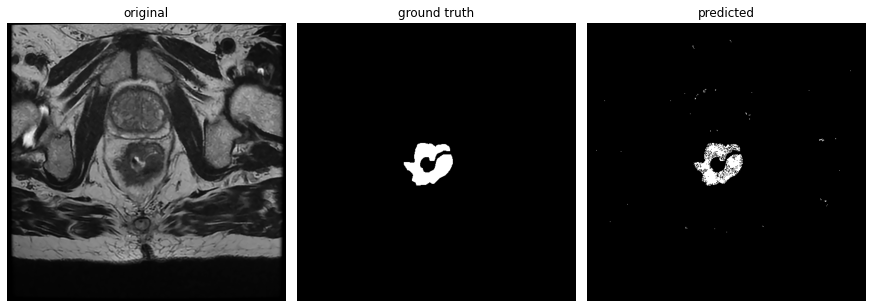

In [12]:
result = loaded_model.predict(X)

predicted = result.reshape(slice.shape[1:3])
ground_truth = labels

show_model_result(ground_truth=ground_truth, predicted=predicted, show_original=True, original=slice[layer, : , :])

## Test on different image

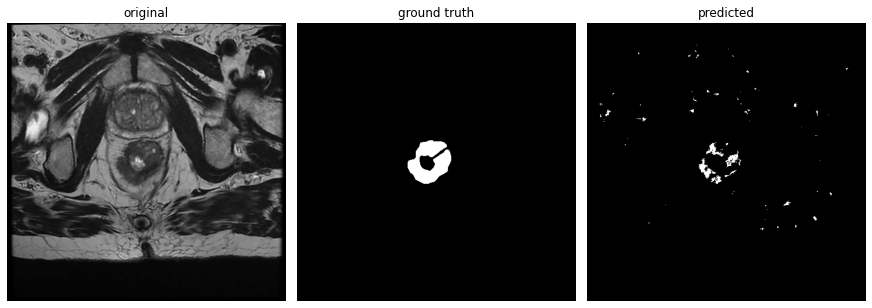

In [13]:
layer = 15

X_2 = features_extraction(slice=slice, layer=layer, ksize=ksize, sigma=sigma, theta=theta, lamb=lamb, gamma=gamma, psi=psi)

result = loaded_model.predict(X_2)

predicted = result.reshape(slice.shape[1:3])
ground_truth = make_mask(slice=slice, layer=layer, positions=positions, xs=xs, ys=ys)

show_model_result(ground_truth=ground_truth, predicted=predicted, show_original=True, original=slice[layer, : , :])

## Training on boxed image

In [14]:
boxed_slice = box_slice(slice=slice, positions=positions, xs=xs, ys=ys)

In [15]:
layer = 14

ksize = np.arange(3, 5, 1)
sigma = np.arange(1, 5, 1)
theta = np.arange(0, 2*np.pi, np.pi/4)
lamb = np.arange(0, 2*np.pi, np.pi/4)
gamma = np.arange(0, 1, 0.5)
psi = np.arange(0, 1, 0.5)

df = features_extraction(slice=boxed_slice, layer=layer, ksize=ksize, sigma=sigma, theta=theta, lamb=lamb, gamma=gamma, psi=psi)

In [16]:
labels = make_mask(slice=boxed_slice, layer=layer, positions=positions, xs=xs, ys=ys)
labels_vect = labels.reshape(-1)
df['labels'] = labels_vect

In [17]:
X_train, X_test, Y_train, Y_test = definig_variables(df, test_size=0.35, random_state=20)

In [18]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, Y_train)

prediction_test = model.predict(X_test)

print_metrics(Y_test=Y_test, prediction_test=prediction_test)  


Accuracy =  0.9971444452921494
Balanced accuracy =  0.9535573530878251
f1_score (macro) =  0.9544729101303961
f1_score (micro) =  0.9971444452921494
homogeneity_score =  0.8083199730135745


In [19]:
filename = 'RF_model_boxed'
save_model(filename=filename, model=model)

In [20]:
loaded_model = load_model(filename=filename)

## Test on trained image

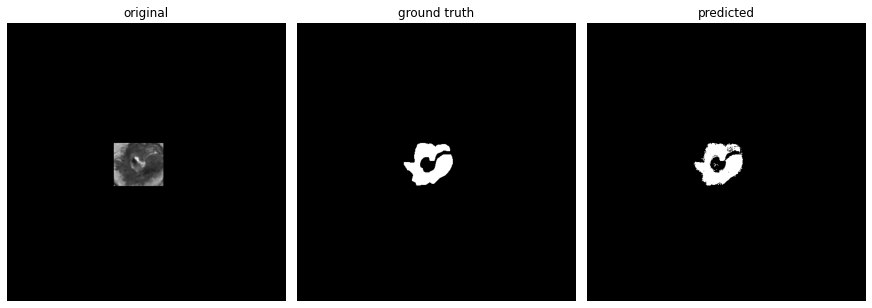

In [21]:
X = df.drop(labels= ['labels'], axis=1)

result = loaded_model.predict(X)

predicted = result.reshape(slice.shape[1:3])
ground_truth = labels

show_model_result(ground_truth=ground_truth, predicted=predicted, show_original=True, original=boxed_slice[layer, : , :])

## Test on different images

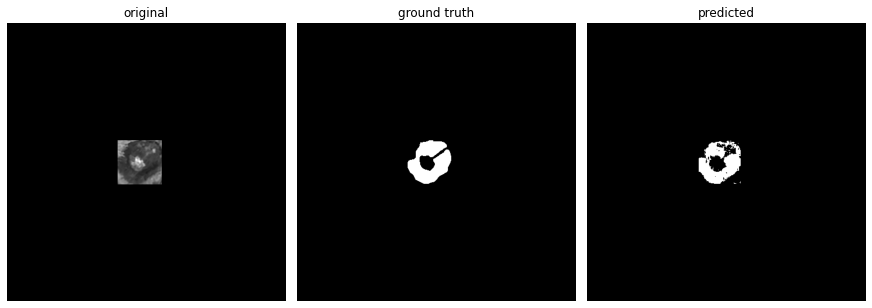

In [22]:
layer = 15

X_2 = features_extraction(slice=boxed_slice, layer=layer, ksize=ksize, sigma=sigma, theta=theta, lamb=lamb, gamma=gamma, psi=psi)

result = loaded_model.predict(X_2)

predicted = result.reshape(slice.shape[1:3])
ground_truth = make_mask(slice=slice, layer=layer, positions=positions, xs=xs, ys=ys)

show_model_result(ground_truth=ground_truth, predicted=predicted, show_original=True, original=boxed_slice[layer, : , :])

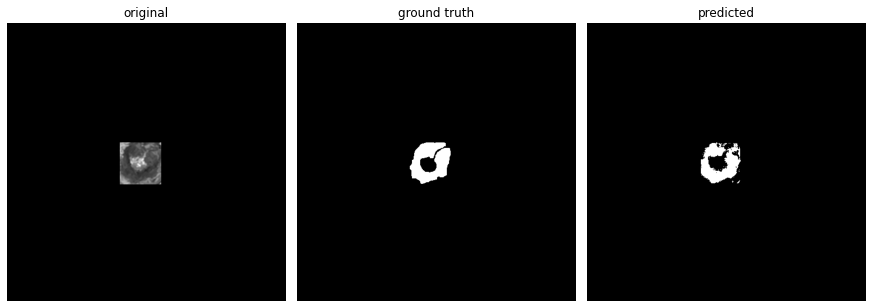

In [23]:
layer = 16

X_2 = features_extraction(slice=boxed_slice, layer=layer, ksize=ksize, sigma=sigma, theta=theta, lamb=lamb, gamma=gamma, psi=psi)

result = loaded_model.predict(X_2)

predicted = result.reshape(slice.shape[1:3])
ground_truth = make_mask(slice=slice, layer=layer, positions=positions, xs=xs, ys=ys)

show_model_result(ground_truth=ground_truth, predicted=predicted, show_original=True, original=boxed_slice[layer, : , :])

### Test performing opening

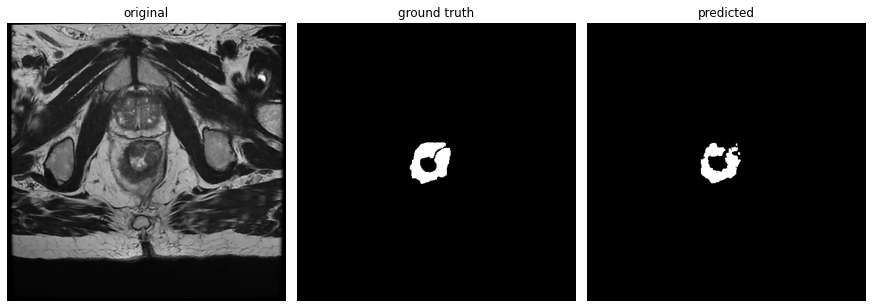

In [24]:
predicted_opening = opening(predicted, ksize=3)
show_model_result(ground_truth=ground_truth, predicted=predicted_opening, show_original=True, original=boxed_slice[layer, : , :])

## Test on full images

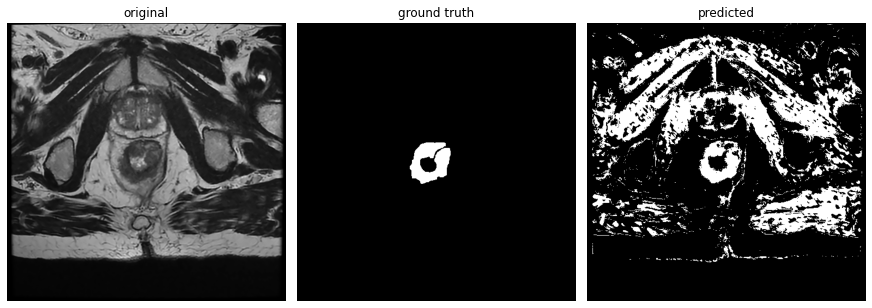

In [25]:
X_full = features_extraction(slice=slice, layer=layer, ksize=ksize, sigma=sigma, theta=theta, lamb=lamb, gamma=gamma, psi=psi)

result = loaded_model.predict(X_full)

predicted = result.reshape(slice.shape[1:3])
ground_truth = make_mask(slice=slice, layer=layer, positions=positions, xs=xs, ys=ys)

show_model_result(ground_truth=ground_truth, predicted=predicted, show_original=True, original=slice[layer, : , :])

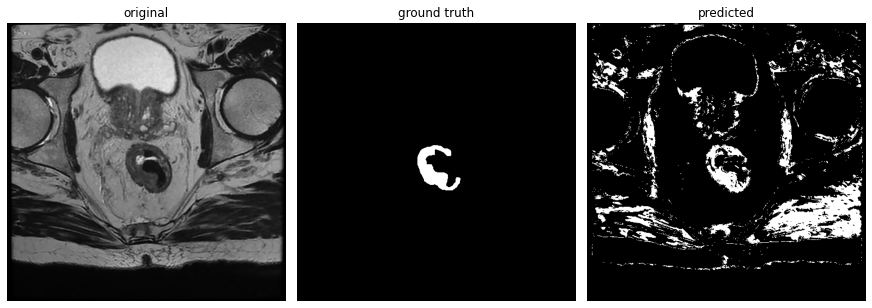

In [26]:
layer = 5

X_full = features_extraction(slice=slice, layer=layer, ksize=ksize, sigma=sigma, theta=theta, lamb=lamb, gamma=gamma, psi=psi)

result = loaded_model.predict(X_full)

predicted = result.reshape(slice.shape[1:3])
ground_truth = make_mask(slice=slice, layer=layer, positions=positions, xs=xs, ys=ys)

show_model_result(ground_truth=ground_truth, predicted=predicted, show_original=True, original=slice[layer, : , :])

## Test performing opening

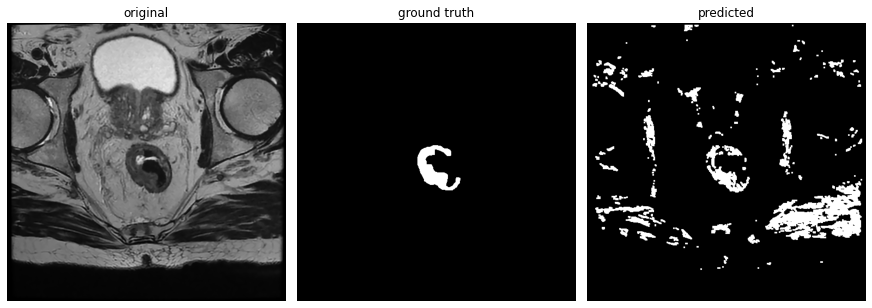

In [27]:
predicted_opening = opening(predicted, ksize=3)
show_model_result(ground_truth=ground_truth, predicted=predicted_opening, show_original=True, original=slice[layer, : , :])